## Challenge: LANL Earthquake Prediction

It is a kaggle challenge found: [here](https://www.kaggle.com/c/LANL-Earthquake-Prediction).

###  Introduction
Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

In this competition, you will address when the earthquake will take place. Specifically, you’ll predict the time remaining before laboratory earthquakes occur from real-time seismic data.

If this challenge is solved and the physics are ultimately shown to scale from the laboratory to the field, researchers will have the potential to improve earthquake hazard assessments that could save lives and billions of dollars in infrastructure.

This challenge is hosted by Los Alamos National Laboratory which enhances national security by ensuring the safety of the U.S. nuclear stockpile, developing technologies to reduce threats from weapons of mass destruction, and solving problems related to energy, environment, infrastructure, health, and global security concerns.


### Data
First of all, we need to understand the data. For training dataset, there are two columns, named: 'acoustic_data' and 'time_to_failure'.
* acoustic_data: some data measured with certain device, which serves as **X** in the model building later on.
* time_to_failure: in micro-seconds, the time gap till the event of the lab earth quake, which serves as **Y**.

For testing, it is a list of data segments of 'acoustic_data', from which to predict the next 'time_to_failure'. It is not clear some of these segments are coming from same quake or each of them coming from separated quakes. 

In [1]:
# loading all the tools!
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sys # system specific
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.optimizers import SGD
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import datetime

Using TensorFlow backend.


Before going deeper into the training and test datasets. Let's first create a function to read the datasets later on. The function should be able to read the **X** (and **Y**) arrays and return the arrays for testing (and training). For training, the previous **N** data points of **X** (e.g. X values from *X[i-N]* to *X[i-1]}* with *N>=1*) should be used to predict the current **Y** (e.g. Y[i]).

In [4]:
def create_dataset(X, Y = None, look_back=1):
  '''
    convert an array of values into a dataset matrix
    input: 
      Training data: X, Y, both are 1-D array
      Testing data: X is 1-D array, while Y is None
      look_back: number of X entries considered to predict the next Y 
    return: formed output X and Y
  '''

  outX, outY = [], []
  for i in range(len(X)-look_back-1):
    x0 = X[i:(i+look_back)] # each X element is a list of $look_back elements
    outX.append( x0 )

  if Y is not None:
    assert (len(X) == len(Y)), "ERROR: Size of X and Y different!"
    for i in range(len(Y)-look_back-1):
      y0 = Y[i+look_back]     # each Y element is a single number
      outY.append( y0 )

  return outX, outY

#### Training Data Exlotory
Take a look at the training data: train.csv, which has a size over 9GB. We need to figure out how many lab earth quakes are there in this dataset. For each lab quake the time_to_failure, hence Y, should constently drop to 0 (or very close to 0). If one sees a sudden increase in the Y value, it means another lab quake experiment has started.

Let's take a look at the first 200M entries to verify this.

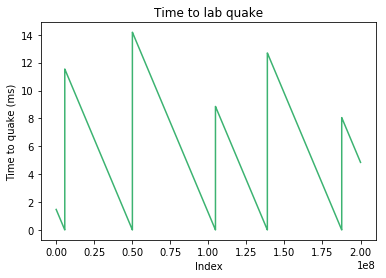

In [3]:
train = pd.read_csv("data/train.csv", nrows = 200000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train.rename({"acoustic_data": "X", "time_to_failure": "Y"}, axis="columns", inplace=True)
plt.plot(train.index.values, train.Y.values, c="mediumseagreen")
plt.title("Time to lab quake")
plt.xlabel("Index")
plt.ylabel("Time to quake (ms)")
plt.show()


Below, we find the index of the last **Y** value for each lab quake experiment. We also find there are in total of 629145480 entries in the training dataset.

| index     | Y[index]               | Y[index + 1] |
|-----------|------------------------|--------------|
| 5656573   | 0.0007954798229500001  | 11.540799987 |
| 50085877  | 0.0006954821747100001  | 14.18059999  |
| 104677355 | 0.00079548506392       | 8.8566999914 |
| 138772452 | 0.0010954868680999998  | 12.693999994 |
| 187641819 | 0.0005954894541        | 8.0554999956 |
| 218652629 | 0.0010954910954        | 7.0589999970 |
| 245829584 | 0.0004954925329900001  | 16.107400000 |
| 307838916 | 0.00069549581485       | 7.9056000019 |
| 338276286 | 0.00019549742592       | 9.6371000039 |
| 375377847 | 0.00049549938876       | 11.426400006 |
| 419368879 | 0.00019550171692       | 11.024200008 |
| 461811622 | 9.550396316600001e-05  | 8.8281000103 |
| 495800224 | 9.5505761692e-05       | 8.5660000120 |
| 528777114 | 0.0008955075072699999  | 14.751800015 |
| 585568143 | 0.00059551051299       | 9.4595000169 |
| 621985672 | 0.0005955124393        | 11.618600019 |

#### Testing Data Exlotory
Take a look at the test data now. The datasets are saved in data/test and the list of the datasets is in tests.txt.


In [5]:
lines = [line.rstrip('\n') for line in open( 'tests.txt' )] 
nline = len(lines)
print("Number of test segmentation samples: ", nline)

Number of test segmentation samples:  2624


Number of data points in the 1st test segmentation sample:  150000


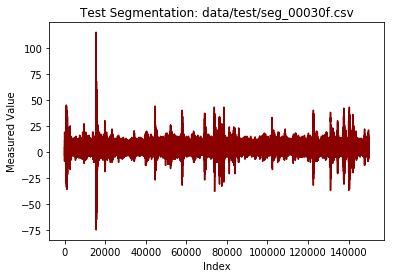

In [6]:
testdata0 = pd.read_csv(lines[0], dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
testdata0.rename({"acoustic_data": "X"}, axis="columns", inplace=True)
npoints = len(testdata0.X.values) 
print("Number of data points in the 1st test segmentation sample: ", npoints)
plt.clf()
plt.plot(range(0,len(testdata0.X.values)), testdata0.X.values, c="darkred")
plt.title("Test Segmentation: " + lines[0])
plt.xlabel("Index")
plt.ylabel("Measured Value")
plt.show()
